In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

In [2]:
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [4]:
original_data = pd.read_csv('data_aa/aa_rpoB.csv', header=None)
original_featrues = pd.read_csv('data_aa/RIF_MIC.csv', header=None)

In [5]:
data = original_data

target = original_featrues

train_data_index = np.random.choice(data.shape[0], size=int(data.shape[0]*0.8), replace=False)
all_indices = np.arange(data.shape[0])
test_data_index = np.setdiff1d(all_indices, train_data_index)

train_data = data.iloc[train_data_index,:]
train_target = target.iloc[train_data_index,:]
train_data = train_data.reset_index(drop=True)
train_target = train_target.reset_index(drop=True)
#don't touch test data, split out validation data from training data during training
test_data = data.iloc[test_data_index,:]
test_target = target.iloc[test_data_index,:]
test_data = test_data.reset_index(drop=True)
test_target = test_target.reset_index(drop=True)

In [6]:
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        train_df,
        mic_df,
        transform = None,
    ):
        self.transform = transform
        self.train_df = train_df
        self.mic_df = mic_df
        if not self.train_df.index.equals(self.mic_df.index):
            raise ValueError(
                "Indices of training data and resistance data don't match up"
            )

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            train = self.train_df.iloc[index]
            mic = self.mic_df.loc[index]
            
        elif isinstance(index, str):
            trains = self.train_df.loc[index]
            mic = self.mic_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )
        
        if self.transform:
            self.mic_mean = self.mic_df.mean()
            self.mic_std = self.mic_df.std()
            mic = (mic - self.mic_mean) / self.mic_std
        
        return  torch.tensor(train),  torch.tensor(mic)
    def __len__(self):
        return self.mic_df.shape[0]
    
training_dataset = Dataset(train_data, train_target, transform=False)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.8), len(training_dataset)-int(len(training_dataset)*0.8)])

In [7]:
torch.tensor(train_target.loc[1])

tensor([0.1200], dtype=torch.float64)

In [8]:
def get_masked_loss(loss_fn):
    """
    Returns a loss function that ignores NaN values
    """

    def masked_loss(y_true, y_pred):
        y_pred = y_pred.view(-1, 1)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # ic(y_true)
        non_nan_mask = ~y_true.isnan()
        # ic(non_nan_mask)
        y_true_non_nan = y_true[non_nan_mask]
        y_pred_non_nan = y_pred[non_nan_mask]

        return loss_fn(y_pred_non_nan, y_true_non_nan)

    return masked_loss

masked_MSE = get_masked_loss(torch.nn.MSELoss())

In [23]:
class Model(nn.Module):
    def __init__(self, in_channel = 869, first_h_layer = 469, out_channel=1, batch_size=1, dropout_rate=0.2, num_dense_layers=3, filter_scaling_factor=1.5):
        super(Model, self).__init__()
        self.batch_size = batch_size
        self.in_channel = in_channel
        self.first_h_layer = first_h_layer
        self.out_channel = out_channel
        self.dense_dropout_rate = dropout_rate
        self.num_dense_layers = num_dense_layers
        self.filter_scaling_factor=filter_scaling_factor
        
        self.dense_layers = nn.ModuleList()
        for i in range(self.num_dense_layers):
            layer = self._dense_layer(100,100)
            self.dense_layers.append(layer)
            # current_num_filters = int(current_num_filters * filter_scaling_factor)

        # self.feature_extraction = nn.Conv1d(in_channels, hidden, kernel_size=kernel_size),]
        self.starting_layers = nn.Sequential(
            nn.Linear(self.in_channel, self.first_h_layer),
            nn.BatchNorm1d(self.first_h_layer),
            nn.ReLU(),
            nn.Dropout(self.dense_dropout_rate),  # Dropout layer after the first ReLU
            nn.Linear(self.first_h_layer, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(self.dense_dropout_rate))  # Dropout layer after the first ReLU

        self.out_layer = nn.Linear(100, self.out_channel)

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
            nn.Dropout(p=self.dense_dropout_rate)
        )

        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = self.starting_layers(x)
        for layer in self.dense_layers:
            x = layer(x)
        out = self.out_layer(x)
        return out

torch.cuda.empty_cache()

epoch = 100
batch_size = 16
lr = 0.001

model = Model(in_channel = 869, 
              first_h_layer = 469, 
              out_channel=1, 
              num_dense_layers=6,
              batch_size=batch_size)

model = model.float()
model = model.to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, drop_last=True, num_workers=4)
# criterion = nn.MSELoss()
criterion = masked_MSE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

In [24]:
print('outpput size: ', model(torch.randn([100, 869],device='cuda')).shape)

outpput size:  torch.Size([100, 1])


# Training

  1%|          | 1/100 [00:10<17:41, 10.72s/it]

Epoch 1
Training loss: 15.76844310760498
Validation loss: 9.451434528359728


  2%|▏         | 2/100 [00:21<17:26, 10.68s/it]

Epoch 2
Training loss: 11.541450500488281
Validation loss: 8.928015397184618


  3%|▎         | 3/100 [00:32<17:15, 10.68s/it]

Epoch 3
Training loss: 10.531012535095215
Validation loss: 9.287333213529266


  4%|▍         | 4/100 [00:42<17:01, 10.64s/it]

Epoch 4
Training loss: 10.042013168334961
Validation loss: 9.103227214306338


  5%|▌         | 5/100 [00:53<16:50, 10.64s/it]

Epoch 5
Training loss: 9.854479789733887
Validation loss: 9.340580949079698


  6%|▌         | 6/100 [01:03<16:32, 10.56s/it]

Epoch 6
Training loss: 9.65014934539795
Validation loss: 8.636928100004305


  7%|▋         | 7/100 [01:14<16:25, 10.59s/it]

Epoch 7
Training loss: 9.700345993041992
Validation loss: 8.83099890702066


  8%|▊         | 8/100 [01:24<16:16, 10.61s/it]

Epoch 8
Training loss: 9.358776092529297
Validation loss: 8.608388406533216


  9%|▉         | 9/100 [01:35<16:03, 10.59s/it]

Epoch 9
Training loss: 9.326067924499512
Validation loss: 8.639151007673808


 10%|█         | 10/100 [01:46<15:57, 10.64s/it]

Epoch 10
Training loss: 8.884967803955078
Validation loss: 8.629872241133322


 11%|█         | 11/100 [01:57<15:56, 10.74s/it]

Epoch 11
Training loss: 9.078946113586426
Validation loss: 8.89627340591279


 12%|█▏        | 12/100 [02:07<15:42, 10.71s/it]

Epoch 12
Training loss: 8.871293067932129
Validation loss: 8.912670173905902


 13%|█▎        | 13/100 [02:18<15:32, 10.72s/it]

Epoch 13
Training loss: 8.760892868041992
Validation loss: 8.595586058985052


 14%|█▍        | 14/100 [02:29<15:19, 10.69s/it]

Epoch 14
Training loss: 8.570062637329102
Validation loss: 9.228289306248012


 15%|█▌        | 15/100 [02:39<15:03, 10.63s/it]

Epoch 15
Training loss: 8.609704971313477
Validation loss: 8.758054553553311


 16%|█▌        | 16/100 [02:50<14:59, 10.71s/it]

Epoch 16
Training loss: 8.811002731323242
Validation loss: 8.280648898412625


 17%|█▋        | 17/100 [03:01<14:47, 10.69s/it]

Epoch 17
Training loss: 8.773372650146484
Validation loss: 8.745575305021404


 18%|█▊        | 18/100 [03:11<14:36, 10.69s/it]

Epoch 18
Training loss: 8.580864906311035
Validation loss: 8.5077704431604


 19%|█▉        | 19/100 [03:22<14:24, 10.68s/it]

Epoch 19
Training loss: 8.327817916870117
Validation loss: 8.614340977955043


 20%|██        | 20/100 [03:33<14:11, 10.64s/it]

Epoch 20
Training loss: 8.476495742797852
Validation loss: 9.345439808042235


 21%|██        | 21/100 [03:43<14:03, 10.68s/it]

Epoch 21
Training loss: 8.417509078979492
Validation loss: 8.52323417487769


 22%|██▏       | 22/100 [03:54<13:54, 10.70s/it]

Epoch 22
Training loss: 8.410431861877441
Validation loss: 8.614120566352751


 23%|██▎       | 23/100 [04:05<13:45, 10.72s/it]

Epoch 23
Training loss: 8.393871307373047
Validation loss: 9.74308392921486


 24%|██▍       | 24/100 [04:16<13:37, 10.76s/it]

Epoch 24
Training loss: 8.350138664245605
Validation loss: 8.502507394573241


 25%|██▌       | 25/100 [04:26<13:24, 10.72s/it]

Epoch 25
Training loss: 8.312909126281738
Validation loss: 8.70060504485577


 26%|██▌       | 26/100 [04:37<13:08, 10.66s/it]

Epoch 26
Training loss: 8.32941722869873
Validation loss: 8.377683215749608


 27%|██▋       | 27/100 [04:48<12:59, 10.67s/it]

Epoch 27
Training loss: 8.399947166442871
Validation loss: 8.971040571731262


 28%|██▊       | 28/100 [04:58<12:48, 10.67s/it]

Epoch 28
Training loss: 8.492871284484863
Validation loss: 9.83379046604699


 29%|██▉       | 29/100 [05:09<12:32, 10.60s/it]

Epoch 29
Training loss: 8.129263877868652
Validation loss: 8.386246348753572


 30%|███       | 30/100 [05:19<12:23, 10.63s/it]

Epoch 30
Training loss: 8.329010009765625
Validation loss: 8.614854142737205


 31%|███       | 31/100 [05:30<12:15, 10.67s/it]

Epoch 31
Training loss: 8.19736385345459
Validation loss: 8.5524260684036


 32%|███▏      | 32/100 [05:41<12:02, 10.62s/it]

Epoch 32
Training loss: 8.106404304504395
Validation loss: 8.506870846954126


 33%|███▎      | 33/100 [05:51<11:52, 10.63s/it]

Epoch 33
Training loss: 8.205401420593262
Validation loss: 8.452089166747788


 34%|███▍      | 34/100 [06:02<11:44, 10.67s/it]

Epoch 34
Training loss: 8.006397247314453
Validation loss: 8.536601331622396


 35%|███▌      | 35/100 [06:13<11:31, 10.64s/it]

Epoch 35
Training loss: 8.436572074890137
Validation loss: 8.513023715434844


 36%|███▌      | 36/100 [06:23<11:19, 10.61s/it]

Epoch 36
Training loss: 8.154573440551758
Validation loss: 8.496831615677035


 37%|███▋      | 37/100 [06:34<11:10, 10.65s/it]

Epoch 37
Training loss: 7.986944675445557
Validation loss: 8.560902700605387


 38%|███▊      | 38/100 [06:45<11:00, 10.65s/it]

Epoch 38
Training loss: 8.160550117492676
Validation loss: 8.995751989036215


 39%|███▉      | 39/100 [06:55<10:49, 10.65s/it]

Epoch 39
Training loss: 8.169297218322754
Validation loss: 9.165572067593697


 40%|████      | 40/100 [07:06<10:39, 10.65s/it]

Epoch 40
Training loss: 8.18095874786377
Validation loss: 8.78701149972166


 41%|████      | 41/100 [07:17<10:28, 10.66s/it]

Epoch 41
Training loss: 8.211301803588867
Validation loss: 8.414086879675445


 42%|████▏     | 42/100 [07:27<10:18, 10.67s/it]

Epoch 42
Training loss: 8.036109924316406
Validation loss: 9.19736714641803


 43%|████▎     | 43/100 [07:38<10:09, 10.68s/it]

Epoch 43
Training loss: 8.096121788024902
Validation loss: 8.750821569585954


 44%|████▍     | 44/100 [07:48<09:54, 10.61s/it]

Epoch 44
Training loss: 8.12936019897461
Validation loss: 8.44775645896603


 45%|████▌     | 45/100 [07:59<09:44, 10.63s/it]

Epoch 45
Training loss: 8.039909362792969
Validation loss: 9.030474483406948


 46%|████▌     | 46/100 [08:10<09:34, 10.63s/it]

Epoch 46
Training loss: 8.046011924743652
Validation loss: 8.900403700196419


 47%|████▋     | 47/100 [08:20<09:22, 10.62s/it]

Epoch 47
Training loss: 7.927028656005859
Validation loss: 8.522811045134493


 48%|████▊     | 48/100 [08:31<09:09, 10.56s/it]

Epoch 48
Training loss: 7.867043972015381
Validation loss: 8.567140394909574


 49%|████▉     | 49/100 [08:41<08:59, 10.57s/it]

Epoch 49
Training loss: 8.125994682312012
Validation loss: 8.98448483797397


 50%|█████     | 50/100 [08:52<08:50, 10.61s/it]

Epoch 50
Training loss: 8.02263355255127
Validation loss: 9.172689882748891


 51%|█████     | 51/100 [09:03<08:41, 10.65s/it]

Epoch 51
Training loss: 8.048957824707031
Validation loss: 8.858972933478928


 52%|█████▏    | 52/100 [09:13<08:29, 10.62s/it]

Epoch 52
Training loss: 7.9321794509887695
Validation loss: 8.78855694478554


 53%|█████▎    | 53/100 [09:24<08:18, 10.62s/it]

Epoch 53
Training loss: 7.837538719177246
Validation loss: 8.44959014835608


 54%|█████▍    | 54/100 [09:35<08:10, 10.66s/it]

Epoch 54
Training loss: 7.9892659187316895
Validation loss: 8.832147173363573


 55%|█████▌    | 55/100 [09:45<07:59, 10.65s/it]

Epoch 55
Training loss: 7.845464706420898
Validation loss: 8.840985269560866


 56%|█████▌    | 56/100 [09:56<07:46, 10.61s/it]

Epoch 56
Training loss: 8.053648948669434
Validation loss: 8.638210834124397


 57%|█████▋    | 57/100 [10:06<07:34, 10.58s/it]

Epoch 57
Training loss: 7.936642169952393
Validation loss: 8.44648009943239


 58%|█████▊    | 58/100 [10:17<07:23, 10.55s/it]

Epoch 58
Training loss: 7.729031085968018
Validation loss: 8.899246083045611


 59%|█████▉    | 59/100 [10:28<07:15, 10.61s/it]

Epoch 59
Training loss: 7.816248893737793
Validation loss: 8.545143203398348


 60%|██████    | 60/100 [10:38<07:06, 10.67s/it]

Epoch 60
Training loss: 7.8481059074401855
Validation loss: 8.951998437424617


 61%|██████    | 61/100 [10:49<06:55, 10.65s/it]

Epoch 61
Training loss: 7.956183433532715
Validation loss: 8.645376620502507


 62%|██████▏   | 62/100 [11:00<06:44, 10.65s/it]

Epoch 62
Training loss: 7.779382228851318
Validation loss: 8.508911190683401


 63%|██████▎   | 63/100 [11:10<06:31, 10.59s/it]

Epoch 63
Training loss: 7.88749885559082
Validation loss: 8.663806987052565


 64%|██████▍   | 64/100 [11:21<06:22, 10.63s/it]

Epoch 64
Training loss: 7.798530101776123
Validation loss: 8.57485497083706


 65%|██████▌   | 65/100 [11:32<06:12, 10.64s/it]

Epoch 65
Training loss: 7.785363674163818
Validation loss: 8.969179151152657


 66%|██████▌   | 66/100 [11:42<06:01, 10.64s/it]

Epoch 66
Training loss: 7.816493988037109
Validation loss: 8.53627004154042


 67%|██████▋   | 67/100 [11:53<05:49, 10.60s/it]

Epoch 67
Training loss: 7.746164321899414
Validation loss: 8.728652278282707


 68%|██████▊   | 68/100 [12:03<05:39, 10.60s/it]

Epoch 68
Training loss: 8.045144081115723
Validation loss: 8.644446019998243


 69%|██████▉   | 69/100 [12:14<05:27, 10.55s/it]

Epoch 69
Training loss: 7.664882659912109
Validation loss: 8.493959963289615


 70%|███████   | 70/100 [12:24<05:16, 10.56s/it]

Epoch 70
Training loss: 7.933467388153076
Validation loss: 8.66427538935061


 71%|███████   | 71/100 [12:35<05:07, 10.60s/it]

Epoch 71
Training loss: 7.9262590408325195
Validation loss: 8.694265695676531


 72%|███████▏  | 72/100 [12:46<04:57, 10.61s/it]

Epoch 72
Training loss: 7.872549533843994
Validation loss: 8.71927766039017


 73%|███████▎  | 73/100 [12:56<04:46, 10.62s/it]

Epoch 73
Training loss: 7.682722091674805
Validation loss: 8.563507956575387


 74%|███████▍  | 74/100 [13:07<04:37, 10.67s/it]

Epoch 74
Training loss: 7.788300514221191
Validation loss: 8.994298657343306


 75%|███████▌  | 75/100 [13:18<04:26, 10.66s/it]

Epoch 75
Training loss: 7.691978931427002
Validation loss: 8.469714597737756


 76%|███████▌  | 76/100 [13:28<04:15, 10.65s/it]

Epoch 76
Training loss: 7.756736755371094
Validation loss: 8.618073239113537


 77%|███████▋  | 77/100 [13:39<04:06, 10.70s/it]

Epoch 77
Training loss: 7.7115020751953125
Validation loss: 9.218682036915988


 78%|███████▊  | 78/100 [13:50<03:55, 10.69s/it]

Epoch 78
Training loss: 7.736465930938721
Validation loss: 8.675636078377218


 79%|███████▉  | 79/100 [14:00<03:44, 10.68s/it]

Epoch 79
Training loss: 7.7692179679870605
Validation loss: 8.7481012849772


 80%|████████  | 80/100 [14:11<03:33, 10.69s/it]

Epoch 80
Training loss: 8.115950584411621
Validation loss: 8.818975538040158


 81%|████████  | 81/100 [14:22<03:23, 10.70s/it]

Epoch 81
Training loss: 7.793498516082764
Validation loss: 8.5546146088687


 82%|████████▏ | 82/100 [14:33<03:12, 10.72s/it]

Epoch 82
Training loss: 7.735090255737305
Validation loss: 8.897467305598372


 83%|████████▎ | 83/100 [14:43<03:01, 10.69s/it]

Epoch 83
Training loss: 7.806632995605469
Validation loss: 9.089561203521143


 84%|████████▍ | 84/100 [14:54<02:51, 10.70s/it]

Epoch 84
Training loss: 7.796334266662598
Validation loss: 8.588065116272807


 85%|████████▌ | 85/100 [15:05<02:41, 10.74s/it]

Epoch 85
Training loss: 7.744539260864258
Validation loss: 8.925123185098267


 86%|████████▌ | 86/100 [15:16<02:30, 10.75s/it]

Epoch 86
Training loss: 7.579724311828613
Validation loss: 8.72781245434508


 87%|████████▋ | 87/100 [15:26<02:19, 10.76s/it]

Epoch 87
Training loss: 7.891041278839111
Validation loss: 8.61430467448098


 88%|████████▊ | 88/100 [15:37<02:08, 10.74s/it]

Epoch 88
Training loss: 7.641602039337158
Validation loss: 8.763042940568859


 89%|████████▉ | 89/100 [15:48<01:58, 10.74s/it]

Epoch 89
Training loss: 7.762248516082764
Validation loss: 8.46388334403799


 90%|█████████ | 90/100 [15:59<01:47, 10.73s/it]

Epoch 90
Training loss: 7.637329578399658
Validation loss: 9.161769301569784


 91%|█████████ | 91/100 [16:09<01:36, 10.71s/it]

Epoch 91
Training loss: 7.828924655914307
Validation loss: 8.847170525536608


 92%|█████████▏| 92/100 [16:20<01:25, 10.70s/it]

Epoch 92
Training loss: 7.835657119750977
Validation loss: 8.450041734001278


 93%|█████████▎| 93/100 [16:31<01:14, 10.70s/it]

Epoch 93
Training loss: 7.773242950439453
Validation loss: 9.19141905541317


 94%|█████████▍| 94/100 [16:41<01:03, 10.64s/it]

Epoch 94
Training loss: 7.764499664306641
Validation loss: 8.733709996552


 95%|█████████▌| 95/100 [16:52<00:53, 10.67s/it]

Epoch 95
Training loss: 7.6319580078125
Validation loss: 8.608004629565686


 96%|█████████▌| 96/100 [17:02<00:42, 10.65s/it]

Epoch 96
Training loss: 7.585865020751953
Validation loss: 8.90970167630792


 97%|█████████▋| 97/100 [17:13<00:31, 10.64s/it]

Epoch 97
Training loss: 7.604702949523926
Validation loss: 8.558929883755535


 98%|█████████▊| 98/100 [17:24<00:21, 10.66s/it]

Epoch 98
Training loss: 7.6135053634643555
Validation loss: 8.584401742669154


 99%|█████████▉| 99/100 [17:34<00:10, 10.63s/it]

Epoch 99
Training loss: 7.752282619476318
Validation loss: 9.140417375988752


100%|██████████| 100/100 [17:45<00:00, 10.65s/it]

Epoch 100
Training loss: 7.824440002441406
Validation loss: 8.806567697495714



/tmp/ipykernel_64275/293922919.py:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


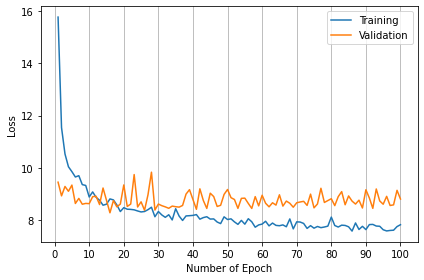

In [25]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

# for x1, y1 in train_loader: 
#     x, y = x1, y1
#     break
for e in tqdm(range(1, epoch+1)):

    train_batch_loss = []
    test_batch_loss = []

    for x, y in train_loader:
        model.train()

        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        # y_batch = y_batch.view(-1)
        # print(x_batch, y_batch)
        # y_batch = one_hot_torch(y).to(device)
        # print('batch y size before flatten:',y_batch.size())
        # y_batch = y_batch.flatten()
        # print('batch y size after flatten:',y_batch.size())
        # print(x_batch.size())
        # print(x_batch.size())
    # For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
        # print(x_batch.size())
        pred = model(x_batch.float())
        # print(pred)
        # print(x_batch)
        # print(pred)
        # pred = pred.unsqueeze(0)
        # ic(pred)
        # ic(y_batch)
        ic(pred.size())
        loss_train = criterion(y_batch, pred)
        ic(loss_train)
        train_batch_loss.append(loss_train.detach())
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('test')
        for x, y in test_loader:
            x_batch = x.to(device)
            y_batch = y.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            # pred = pred.unsqueeze(0)

            loss_test = criterion(y_batch, pred)
            test_batch_loss.append(loss_test )
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
# scheduler.step(torch.mean(torch.stack(test_batch_loss)))
# print(train_batch_loss)
# print(test_batch_loss)
# print(f"Training loss: {np.mean(train_batch_loss)}")
# print(f"Validation loss: {np.mean(test_batch_loss)}")
print('==='*10)
torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/rif_model_overfit.pt')
fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
# ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
# fig.savefig(f'./graphs1/loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}.png')
# print(f'./graphs1/loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}.png')

In [ ]:
def save_to_file(file_path, appendix, epoch, lr, dr, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]

    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, DR: {dr}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")
        
def training(appendix:str, epoch:int, dropout_rate:float, lr:float, batch_size:int=16, train_dataset=train_dataset, val_dataset=val_dataset, verbose:bool=False, graphics:bool=False):
    print(f"====lr: {lr}, dropout rate: {dropout_rate}")
    torch.cuda.empty_cache()
    import gc; gc.collect()
    # ic.enable()
    ic.disable()
    
    model = Model(in_channel = 869, 
              first_h_layer = 469, 
              out_channel=1, 
              num_dense_layers=4,
              batch_size=batch_size,
              dropout_rate=dropout_rate)
    
    model = model.float()
    model = model.to(device)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, drop_last=True, num_workers=4)
    # criterion = nn.MSELoss()
    criterion = masked_MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        for x, y in train_loader:
            x_batch = torch.squeeze(x, 0).to(device)
            y_batch = y.to(device)
            x_batch = x_batch.float()
            y_batch = y_batch.float()

            pred = model(x_batch.float())
            # print('====')
            # print(pred)

            ic(pred.size())
            loss_train = criterion(y_batch, pred)
            ic(loss_train)
            train_batch_loss.append(loss_train.detach())
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('test')
            for x, y in test_loader:
                x_batch = x.to(device)
                y_batch = y.to(device)
                pred = model(x_batch.float())
                loss_test = criterion(y_batch, pred)
                test_batch_loss.append(loss_test )
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
        if verbose:
            print(f'Epoch {e}')
            print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
            print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
            print('==='*10)
        
    save_to_file('trials_rif.txt', appendix ,epoch, lr, dropout_rate, train_epoch_loss, test_epoch_loss)
    print('final train loss:',train_epoch_loss[-1])
    print('final test loss:', test_epoch_loss[-1])
    if graphics:
        fig, ax = plt.subplots()
        x = np.arange(1, epoch+1, 1)
        ax.plot(x, train_epoch_loss,label='Training')
        ax.plot(x, test_epoch_loss,label='Validation')
        ax.legend()
        ax.set_xlabel("Number of Epoch")
        ax.set_ylabel("Loss")
        ax.set_xticks(np.arange(0, epoch+1, 10))
        ax.set_title(f'Loss: Learning_rate:{lr},dr:{dropout_rate}')
        # ax_2 = ax.twinx()
        # ax_2.plot(history["lr"], "k--", lw=1)
        # ax_2.set_yscale("log")
        # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
        ax.grid(axis="x")
        fig.tight_layout()
        fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC/graph_rif/{appendix}_loss_lr_{lr}_dr_{dropout_rate}.png')
        fig.show()
    return torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy(), torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()
# training(epoch=50, dropout_rate=0.2, lr=0.001, batch_size=128, train_dataset=train_dataset, val_dataset=val_dataset, graphics=True)

# Grid search

====lr: 1e-05, dropout rate: 0


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [08:24<00:00, 10.09s/it]
/tmp/ipykernel_37680/3412070344.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


final train loss: 8.634138
final test loss: 10.203509562029387
====lr: 0.0001, dropout rate: 0


100%|██████████| 50/50 [08:28<00:00, 10.17s/it]
/tmp/ipykernel_37680/3412070344.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


final train loss: 7.381178
final test loss: 10.165419612655484
====lr: 0.001, dropout rate: 0


100%|██████████| 50/50 [08:30<00:00, 10.22s/it]
/tmp/ipykernel_37680/3412070344.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


final train loss: 7.1936502
final test loss: 9.479649297084608
====lr: 0.01, dropout rate: 0


100%|██████████| 50/50 [08:32<00:00, 10.25s/it]
/tmp/ipykernel_37680/3412070344.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


final train loss: 7.414858
final test loss: 9.445039235878342
====lr: 0.1, dropout rate: 0


100%|██████████| 50/50 [08:29<00:00, 10.19s/it]

final train loss: 8.067965
final test loss: 9.382007550199177
Best lr: 0.1, Best dropout rate: 0, Best result: 9.382007550199177



/tmp/ipykernel_37680/3412070344.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


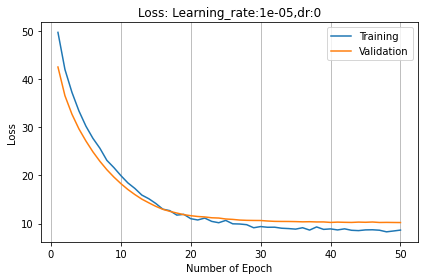

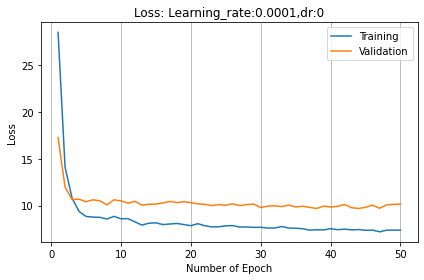

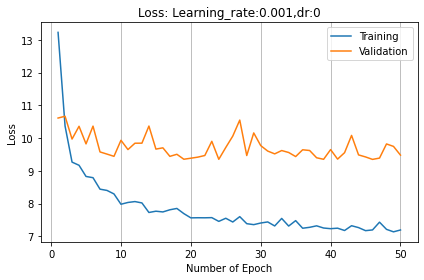

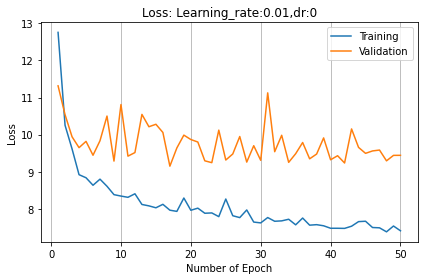

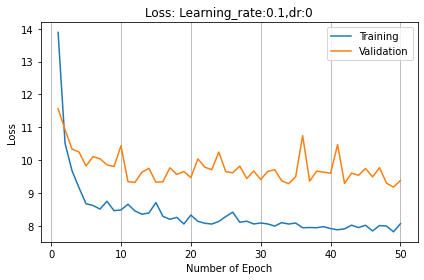

In [30]:
lr_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,]
# dropout_rates = [0.2, 0.3, 0.4,0.5]
dropout_rates = [0]

# lr_values = [0.001]
# dropout_rates = [0.5]

results_test = []
results_train = []

for lr in lr_values:
    for dropout_rate in dropout_rates:
        result_test, result_train = training('5layers', epoch=50, dropout_rate=dropout_rate, lr=lr, batch_size=16, train_dataset=train_dataset, val_dataset=val_dataset, graphics=True)
        results_test.append((lr, dropout_rate, result_test))
        results_train.append((lr, dropout_rate, result_train))
    # print('lr:', lr, 'done')   
    # print(f'Learning Rate: {lr}, Dropout Rate: {dropout_rate}, Test Result: {result_test}')
# Sort the results based on the validation loss

# with open(f'results_test_lr{lr}_dr{dropout_rate}.txt', 'w') as file:
#     for lr, dropout_rate, result in results_test:
#         file.write(f'Learning Rate: {lr}, Dropout Rate: {dropout_rate}, Test Result: {result}\n')

# # Save the train results to a text file
# with open(f'results_train_lr{lr}_dr{dropout_rate}.txt', 'w') as file:
#     for lr, dropout_rate, result in results_train:
#         file.write(f'Learning Rate: {lr}, Dropout Rate: {dropout_rate}, Train Result: {result}\n')

results_test.sort(key=lambda x: x[2])

# Print the best lr and dropout rate
best_lr, best_dropout_rate, best_result = results_test[0]
print(f"Best lr: {best_lr}, Best dropout rate: {best_dropout_rate}, Best result: {best_result}")

In [25]:
results_test[-1]

(1e-05, 0, array(10.21718385))